# II. Using Glove Embedding and look at Emoji Clusters

<a id='table'></a>
## Table of Contents
<ul>
<li><a href="#loading_emojis">1. Loading Emojipedia DataFrame and some preprocessing</a></li>
<li><a href="#glove_embedding">2. Glove Embedding</a></li>
<li><a href="#clusters">3. Analyzing different Clusters</a></li>
<li><a href="#help_function">4. Creating a help DataFrame for Dataset Creation </a></li>
</ul>

In [1]:
import pandas as pd
import numpy as np
import math
import pickle
import spacy
nlp = spacy.load('en_core_web_lg')
from helper_functions import *
import seaborn as sb

### Text used for test 

In [2]:
aladdin = open("Books/aladdin_page.txt").read()
file = nlp(aladdin)

In [3]:
grimm = open("Books/grimm_small.txt").read()
file_grimm = nlp(grimm)

In [4]:
greek = open("Books/Greek_heroes_small.txt").read()
file_greek = nlp(greek)

In [5]:
for num, sentence in enumerate(file.sents):
    print(f'{num}: {sentence}')

0: THE STORY OF ALADDIN AND HIS MAGICAL LAMP

1: There once lived, in one of the large and rich cities of China, a tailor, named Mustapha.
2: He was very poor.
3: He could hardly, by his daily labor, maintain himself and his family, which consisted only of his wife and a son.


4: His son, who was called Aladdin, was a very careless and idle fellow.
5: He was disobedient to his father and mother, and would go out early in the morning and stay out all day, playing in the streets and public places with idle children of his own age.


6: When he was old enough to learn a trade, his father took him into his own shop, and taught him how to use his needle; but all his father’s endeavors to keep him to his work were vain, for no sooner was his back turned than he was gone for that day.
7: Mustapha chastised him; but Aladdin was incorrigible, and his father, to his great grief, was forced to abandon him to his idleness, and was so much troubled about him that he fell sick and died in a few mon

<a id='loading_emojis'></a>
## 1. Loading Emojipedia DataFrame
<a href="#table">Back to the top </a>

In [6]:
# Loading the dataframe obtained after scraping EmojiPedia
csv_loc = "../Emojipedia/emojipedia_df_02.csv"
emoji_df = pd.read_csv(csv_loc)

In [7]:
emoji_df.sample(10)

Unnamed: 0 emoji_symbol             emoji_name        emoji_code  \
1723        1723           🇹🇩           🇩 Flag: Chad  U+1F1F9, U+1F1E9   
451          451            💨           Dashing Away           U+1F4A8   
607          607           ☁️                ️ Cloud    U+2601, U+FE0F   
1681        1681           🇵🇪           🇪 Flag: Peru  U+1F1F5, U+1F1EA   
866          866           🏖️  ️ Beach with Umbrella   U+1F3D6, U+FE0F   
1630        1630           🇰🇼         🇼 Flag: Kuwait  U+1F1F0, U+1F1FC   
1348        1348            🔁          Repeat Button           U+1F501   
367          367            👪                 Family           U+1F46A   
1094        1094           🏷️                ️ Label   U+1F3F7, U+FE0F   
658          658            🥬            Leafy Green           U+1F96C   

                                      emoji_description  
1723  The flag for Chad, which may show as the lette...  
451   A cartoon-styled gust of air. Depicted as a sm...  
607   A fluffy, white cloud, as acumulus. May be use...  
1681  The flag forPeru, which may show as the letter...  
866   A beach showing sand, and an umbrella for prot...  
1630  The flag forKuwait, which may show as the lett...  
1348  Circular arrows pointing in a clockwise direct...  
367   A family unit shown with twoadultsand onechild...  
1094  A light-brown or yellow rectangular tag, as la...  
658   A head of a rich green leaf vegetable, usually...

In [8]:
emoji_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1764 entries, 0 to 1763
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         1764 non-null   int64 
 1   emoji_symbol       1764 non-null   object
 2   emoji_name         1764 non-null   object
 3   emoji_code         1764 non-null   object
 4   emoji_description  1764 non-null   object
dtypes: int64(1), object(4)
memory usage: 69.0+ KB


### Make a copy of the emojis df 

In [9]:
# We'll work on a copy of the original dataframe
emojis = emoji_df.copy()

### NLP preprocessing on description

In [10]:
emojis.head(2)

Unnamed: 0 emoji_symbol                   emoji_name emoji_code  \
0           0            😀                Grinning Face    U+1F600   
1           1            😃  Grinning Face with Big Eyes    U+1F603   

                                   emoji_description  
0  A yellow face with simple, open eyes and a bro...  
1  A yellow face with smiling eyes and a broad, o...

> We'll put the descriptions in lower cases, remove the stopwords and punctuations

In [11]:
help(some_preprocessing)

Help on function some_preprocessing in module helper_functions:

some_preprocessing(description, remove_stopw=True)
    Returns the preprocessed description.
    
    Parameters:
        description (str): The string description of the emoji, that will be
                           preprocessed.
    
        remove_stopw (bool): Default = True, if False => Stopwords aren't removed
    
    Returns:
        some_preprocessing(description): A list of string of lower case tokens
        punctuations and stopwords)



In [12]:
# Adding a column with preprocessed description
emojis["preprocessed_description"] = emojis["emoji_description"].apply(lambda x: some_preprocessing(x,True))

In [13]:
# Test
emojis.sample(3)

Unnamed: 0 emoji_symbol   emoji_name emoji_code  \
917          917            🚇        Metro    U+1F687   
913          913            🚃  Railway Car    U+1F683   
1042        1042            📻        Radio    U+1F4FB   

                                      emoji_description  \
917   A metro: frequent underground train found in b...   
913   A railway (railroad)car (carriage)that is gene...   
1042  A classic portable radio, as used to listen to...   

                               preprocessed_description  
917   [metro, frequent, underground, train, found, a...  
913   [railway, railroad, car, carriage, generally, ...  
1042  [classic, portable, radio, used, listen, music...

<a id='glove_embedding'></a>
## 2. Glove Embedding (Global Vector)
<a href="#table">Back to the top </a>

> **Global Vectors for Word Representation**, or GloVe, is an _“unsupervised learning algorithm for obtaining vector representations for words.”_ Simply put, GloVe allows us to take a corpus of text, and intuitively transform each word in that corpus into a position in a high-dimensional space. This means that similar words will be placed together.


### a. Loading the vectors

> Before we load the vectors in code, we have to understand how the text file is formatted.
Each line of the text file contains a word, followed by N numbers. The N numbers describe the vector of the word’s position. N may vary depending on which vectors you downloaded, for me, N is 50, since I am using glove.6B.50d.
_Here is an example line from the text file, shortened to the first three dimensions:_

**business** 0.023693 0.13316 0.023131 ...

In [14]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

In [12]:
# Writing down in a dictionnary
"""
glove_lookup = {}

with open("glove.6B.100d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        glove_lookup[word] = vector  
"""

### b. Saving and Loading the lookup dictionnary with Pickle

In [15]:
filename = 'Saved_Embeddings/glove_lookup'

In [16]:
## ONLY EXECUTE THIS CELL ONCE FOR SAVING THE GLOVE LOOKUP DICTIONARY
# Save the Glove Embedding Lookup Table
"""
outfile = open(filename,'wb')
pickle.dump(glove_lookup,outfile)
outfile.close()
"""

"\noutfile = open(filename,'wb')\npickle.dump(glove_lookup,outfile)\noutfile.close()\n"

In [17]:
## ONLY EXECUTE THIS CELL ONCE FOR LOADING THE GLOVE LOOKUP DICTIONARY
# Loading the Glove Embedding Lookup Table
infile = open(filename,'rb')
glove_lookup = pickle.load(infile)
infile.close()

### c. Average Glove vector for the descriptions

> **Basic Idea:** Getting the Glove Vector representation of each word present in the cleaned description and aggregating those by averaging to 1 Vector. 

In [18]:
help(avg_glove_vector)

Help on function avg_glove_vector in module helper_functions:

avg_glove_vector(descr_list, emoji_2_embedding_lookup)
    Returns from a preprocessed list of the emoji description the average embedding
    
    Parameters:
        descr_list (list): List containing string tokens of preprocessed emoji description
    
        emoji_2_embedding_lookup (dict): dictionnary with as keys the words of the
                        corpus and the values the vector of that word
    
    Returns:
        An embedding vector with the same dimensions as the Word Embedding used



In [19]:
emojis["avg_glove_embedding"] = emojis['preprocessed_description']\
                                            .apply(lambda x: avg_glove_vector(x, glove_lookup))

In [20]:
emojis.head(2)

Unnamed: 0 emoji_symbol                   emoji_name emoji_code  \
0           0            😀                Grinning Face    U+1F600   
1           1            😃  Grinning Face with Big Eyes    U+1F603   

                                   emoji_description  \
0  A yellow face with simple, open eyes and a bro...   
1  A yellow face with smiling eyes and a broad, o...   

                            preprocessed_description  \
0  [yellow, face, simple, open, eyes, broad, open...   
1  [yellow, face, smiling, eyes, broad, open, smi...   

                                 avg_glove_embedding  
0  [-0.05930326535765614, 0.35218397080898284, 0....  
1  [-0.04583876235410571, 0.34958994686603545, 0....

#### Check if some some empty vectors

In [21]:
import warnings
warnings.filterwarnings('ignore')
emojis[emojis.avg_glove_embedding==""]

Unnamed: 0 emoji_symbol     emoji_name emoji_code emoji_description  \
1236        1236            🕧  Twelve-Thirty    U+1F567     Twelve-Thirty   
1238        1238            🕜     One-Thirty    U+1F55C        One-Thirty   
1240        1240            🕝     Two-Thirty    U+1F55D        Two-Thirty   
1242        1242            🕞   Three-Thirty    U+1F55E      Three-Thirty   
1244        1244            🕟    Four-Thirty    U+1F55F       Four-Thirty   
1246        1246            🕠    Five-Thirty    U+1F560       Five-Thirty   
1248        1248            🕡     Six-Thirty    U+1F561        Six-Thirty   
1250        1250            🕢   Seven-Thirty    U+1F562      Seven-Thirty   
1252        1252            🕣   Eight-Thirty    U+1F563      Eight-Thirty   
1254        1254            🕤    Nine-Thirty    U+1F564       Nine-Thirty   
1256        1256            🕥     Ten-Thirty    U+1F565        Ten-Thirty   
1258        1258            🕦  Eleven-Thirty    U+1F566     Eleven-Thirty   

     preprocessed_description avg_glove_embedding  
1236                       []                      
1238                       []                      
1240                       []                      
1242                       []                      
1244                       []                      
1246                       []                      
1248                       []                      
1250                       []                      
1252                       []                      
1254                       []                      
1256                       []                      
1258                       []

In [22]:
emojis.iloc[1236:1259,:]

Unnamed: 0 emoji_symbol      emoji_name emoji_code emoji_description  \
1236        1236            🕧   Twelve-Thirty    U+1F567     Twelve-Thirty   
1237        1237            🕐     One O’Clock    U+1F550       One O’Clock   
1238        1238            🕜      One-Thirty    U+1F55C        One-Thirty   
1239        1239            🕑     Two O’Clock    U+1F551       Two O’Clock   
1240        1240            🕝      Two-Thirty    U+1F55D        Two-Thirty   
1241        1241            🕒   Three O’Clock    U+1F552     Three O’Clock   
1242        1242            🕞    Three-Thirty    U+1F55E      Three-Thirty   
1243        1243            🕓    Four O’Clock    U+1F553      Four O’Clock   
1244        1244            🕟     Four-Thirty    U+1F55F       Four-Thirty   
1245        1245            🕔    Five O’Clock    U+1F554      Five O’Clock   
1246        1246            🕠     Five-Thirty    U+1F560       Five-Thirty   
1247        1247            🕕     Six O’Clock    U+1F555       Six O’Clock   
1248        1248            🕡      Six-Thirty    U+1F561        Six-Thirty   
1249        1249            🕖   Seven O’Clock    U+1F556     Seven O’Clock   
1250        1250            🕢    Seven-Thirty    U+1F562      Seven-Thirty   
1251        1251            🕗   Eight O’Clock    U+1F557     Eight O’Clock   
1252        1252            🕣    Eight-Thirty    U+1F563      Eight-Thirty   
1253        1253            🕘    Nine O’Clock    U+1F558      Nine O’Clock   
1254        1254            🕤     Nine-Thirty    U+1F564       Nine-Thirty   
1255        1255            🕙     Ten O’Clock    U+1F559       Ten O’Clock   
1256        1256            🕥      Ten-Thirty    U+1F565        Ten-Thirty   
1257        1257            🕚  Eleven O’Clock    U+1F55A    Eleven O’Clock   
1258        1258            🕦   Eleven-Thirty    U+1F566     Eleven-Thirty   

     preprocessed_description  \
1236                       []   
1237             [one, clock]   
1238                       []   
1239             [two, clock]   
1240                       []   
1241           [three, clock]   
1242                       []   
1243            [four, clock]   
1244                       []   
1245            [five, clock]   
1246                       []   
1247             [six, clock]   
1248                       []   
1249           [seven, clock]   
1250                       []   
1251           [eight, clock]   
1252                       []   
1253            [nine, clock]   
1254                       []   
1255             [ten, clock]   
1256                       []   
1257          [eleven, clock]   
1258                       []   

                                    avg_glove_embedding  
1236                                                     
1237  [-0.004869997501373291, 0.09460999071598053, 0...  
1238                                                     
1239  [0.007145002484321594, 0.011214986443519592, -...  
1240                                                     
1241  [0.07361049950122833, 0.033689990639686584, -0...  
1242                                                     
1243  [0.06255099922418594, 0.09024499356746674, -0....  
1244                                                     
1245  [0.13915599882602692, 0.08734999597072601, -0....  
1246                                                     
1247  [0.2013150006532669, 0.09059499204158783, -0.0...  
1248                                                     
1249  [0.1828949972987175, 0.052799999713897705, 0.0...  
1250                                                     
1251  [0.13058599829673767, 0.1170549988746643, -0.0...  
1252                                                     
1253  [0.1947299987077713, 0.03729499876499176, -0.0...  
1254                                                     
1255  [0.09214749932289124, -0.047345004975795746, -...  
1256                                                     
1257  [0.1426679976284504, -0.02402500808238983, -0....  
1258

In [23]:
# Shape before
emojis.shape

(1764, 7)

In [24]:
# Let's remove those rows
warnings.filterwarnings('ignore')
emojis = emojis[emojis.avg_glove_embedding!=""]

In [25]:
# Test: shape after
emojis.shape

(1752, 7)

### Keeping the list of emoji symbols and names

In [26]:
emoji_symbols =  list(emojis.emoji_symbol)
emoji_names =  list(emojis.emoji_name)

### d. Vector Visualization with  t-SNE 

In [27]:
glove_vectors = list(emojis.avg_glove_embedding)

In [28]:
help(building_tsne_df)

Help on function building_tsne_df in module helper_functions:

building_tsne_df(emoji_symbols, emoji_names, emb_emoji_vectors)
    Returns a DataFrame with a t-SNE 2D reduction of the emoji description embedding
    
    Parameters:
        emoji_symbols (list): List of emoji symbols
    
        emoji_names (list): List of correlated emoji names
    
        emb_emoji_vectors(list): list of embedded emoji description
    
    Returns:
        An embedding vector with the same dimensions as the Word Embedding used



In [29]:
glove_tsne_df = building_tsne_df(emoji_symbols, emoji_names, glove_vectors)

In [30]:
help(tsne_plot)

Help on function tsne_plot in module helper_functions:

tsne_plot(tsne_2d_df, graph_title)
    Returns a 2D plotly graph of the t-SNE dimension reduction of the emoji descripition embedding
    
    Parameters:
        tsne_2d_df (DataFrame): DataFrame obtained with building_tsne_df(emoji_symbols,
        emoji_names, emb_emoji_vectors)
    
        graph_title (str): Desired title of the graph
    
    Returns:
        A 2D plotly graph of the t-SNE dimension reduction of the emoji descripition embedding



In [31]:
graph_title = 'Emojis Description with Glove Vector Space'
tsne_plot(glove_tsne_df, graph_title)

### e. Finding Similar Vectors

> source: https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db

In [32]:
# Building the emoji to averaged description GloVe Embedding Dictionnary
emoji_symb2emb_dic = {}
for i in range(len(emoji_symbols)):
    emoji_symb2emb_dic[emoji_symbols[i]] = glove_vectors[i]

In [33]:
with open('Saved_Variables/avg_glove_embedding.pkl', 'rb') as f:
    dict_emoji = pickle.load(f)

In [34]:
dict_emoji

{'😀': array([-0.05930327,  0.35218397,  0.43395171, -0.12258554,  0.06305937,
         0.37891134, -0.2883654 ,  0.09169994, -0.05414372, -0.32154709,
        -0.26650945,  0.02116586,  0.39788769,  0.07167966,  0.31061497,
         0.210968  , -0.17650148,  0.20071566,  0.11206828, -0.10764008,
         0.0686942 ,  0.19454968, -0.10344411, -0.18674517,  0.50585883,
         0.4840676 , -0.13399481, -0.277326  ,  0.10005874, -0.24886603,
         0.21497052,  0.16937448, -0.00785789, -0.10838272,  0.34476989,
         0.05951737, -0.18924697,  0.02182089,  0.20252986, -0.03828259,
         0.02880191, -0.43547434,  0.08455885, -0.14119326, -0.15976694,
         0.11818975,  0.16721946,  0.23364474, -0.01106368, -0.377144  ,
         0.0034518 , -0.19946888,  0.21372275,  0.83450255, -0.056626  ,
        -1.51512717,  0.12700671, -0.01079069,  0.77324663,  0.11053886,
         0.18606523,  0.85109485, -0.29809348,  0.10459246,  0.37532843,
         0.08264265,  0.45009277,  0.10899173,

In [35]:
help(translate_text)

Help on function translate_text in module helper_functions:

translate_text(spacy_nlp_file, emoji_2_embedding_lookup, emoji_symb2emb_dic, distance_type='euclidean')
    Returns the input spacy_file split in sentences with the closest emoji
    
    Parameters:
        spacy_nlp_file) (spacy nlp object) : Text as nlp object that we want to translate
    
        emoji_2_embedding_lookup (dict): dictionnary with as keys the words of the
                        corpus and the values the vector of that word
    
        emoji_symb2emb_dic (dict): keys emoji_symbols values averaged description Embedding
    
        distance_type (str): default is "euclidiean", but also "cosine" possible
    
    Returns:
        The input spacy_file split in sentences with the closest emoji



In [36]:
# With Euclidean Distance
translate_text(file, glove_lookup, emoji_symb2emb_dic)

0: THE STORY OF ALADDIN AND HIS MAGICAL LAMP

['💎', '🔦', '🕯️']

1: There once lived, in one of the large and rich cities of China, a tailor, named Mustapha.
['\U0001f960', '☪️', '🎍']

2: He was very poor.
['🚸', '🏥', '🚋']

3: He could hardly, by his daily labor, maintain himself and his family, which consisted only of his wife and a son.


['👪', '🙋', '🏠']

4: His son, who was called Aladdin, was a very careless and idle fellow.
['🙉', '🙈', '👹']

5: He was disobedient to his father and mother, and would go out early in the morning and stay out all day, playing in the streets and public places with idle children of his own age.


['💑', '💏', '🚶']

6: When he was old enough to learn a trade, his father took him into his own shop, and taught him how to use his needle; but all his father’s endeavors to keep him to his work were vain, for no sooner was his back turned than he was gone for that day.
['👻', '🤗', '🚶']

7: Mustapha chastised him; but Aladdin was incorrigible, and his father, to his 

In [38]:
# With Cosine Distance
translate_text(file, glove_lookup, emoji_symb2emb_dic, "cosine")

0: THE STORY OF ALADDIN AND HIS MAGICAL LAMP

['💎', '🔦', '🕯️']

1: There once lived, in one of the large and rich cities of China, a tailor, named Mustapha.
['🏠', '☪️', '🤼']

2: He was very poor.
['🚸', '🏥', '🚋']

3: He could hardly, by his daily labor, maintain himself and his family, which consisted only of his wife and a son.


['👫', '🙋', '🏠']

4: His son, who was called Aladdin, was a very careless and idle fellow.
['🙉', '👻', '🙈']

5: He was disobedient to his father and mother, and would go out early in the morning and stay out all day, playing in the streets and public places with idle children of his own age.


['💑', '🏠', '🚶']

6: When he was old enough to learn a trade, his father took him into his own shop, and taught him how to use his needle; but all his father’s endeavors to keep him to his work were vain, for no sooner was his back turned than he was gone for that day.
['👻', '🤗', '🚶']

7: Mustapha chastised him; but Aladdin was incorrigible, and his father, to his great gri

In [39]:
translate_by_keywords(file, glove_lookup, emoji_symb2emb_dic)

0: THE STORY OF ALADDIN AND HIS MAGICAL LAMP

STORY  --- EMOJI --->   ['📘', '\U0001f9df', '🎞️']
ALADDIN  --- EMOJI --->   ['🦋', '🏙️', '🍩']
LAMP  --- EMOJI --->   ['🛋️', '🕯️', '💡']

1: There once lived, in one of the large and rich cities of China, a tailor, named Mustapha.
cities  --- EMOJI --->   ['🚌', '🚋', '🚊']
China  --- EMOJI --->   ['🇹🇼', '🇭🇰', '🌏']
tailor  --- EMOJI --->   ['💁', '🍩', '\U0001f9f6']
Mustapha  --- EMOJI --->   ['🍈', '🥜', '🍔']

2: He was very poor.

3: He could hardly, by his daily labor, maintain himself and his family, which consisted only of his wife and a son.


labor  --- EMOJI --->   ['👨\u200d⚕️', '👩\u200d⚕️', '⚕️']
family  --- EMOJI --->   ['👨\u200d👩\u200d👧', '🏠', '👨\u200d👩\u200d👧\u200d👦']
wife  --- EMOJI --->   ['👨\u200d👩\u200d👧\u200d👦', '👧', '👸']
son  --- EMOJI --->   ['👨\u200d👩\u200d👧\u200d👦', '👨\u200d👩\u200d👧', '👨\u200d👩\u200d👦\u200d👦']

4: His son, who was called Aladdin, was a very careless and idle fellow.
son  --- EMOJI --->   ['👨\u200d👩\u200d👧\u200d👦'

uncle  --- EMOJI --->   ['👨\u200d👩\u200d👧\u200d👦', '👨\u200d👩\u200d👧', '👨\u200d👩\u200d👦\u200d👦']

20: “Mother,” said he, “have I an uncle?”
Mother  --- EMOJI --->   ['👨\u200d👩\u200d👧\u200d👦', '👧', '👨\u200d👩\u200d👧']
uncle  --- EMOJI --->   ['👨\u200d👩\u200d👧\u200d👦', '👨\u200d👩\u200d👧', '👨\u200d👩\u200d👦\u200d👦']

21: “No, child,” replied his mother, “you have no uncle by your father’s side or mine.”
child  --- EMOJI --->   ['👧', '👩', '👩\u200d⚕️']
mother  --- EMOJI --->   ['👨\u200d👩\u200d👧\u200d👦', '👧', '👨\u200d👩\u200d👧']
uncle  --- EMOJI --->   ['👨\u200d👩\u200d👧\u200d👦', '👨\u200d👩\u200d👧', '👨\u200d👩\u200d👦\u200d👦']
father  --- EMOJI --->   ['👨\u200d👩\u200d👧\u200d👦', '👨\u200d👩\u200d👧', '👨\u200d👩\u200d👦\u200d👦']
side  --- EMOJI --->   ['🚔', '👁️', '🤚']
mine  --- EMOJI --->   ['⛏️', 'Ⓜ️', '🚜']

22: “I am just now come,” said Aladdin, “from a man who says he is my uncle and my father’s brother.
Aladdin  --- EMOJI --->   ['🦋', '🏙️', '🍩']
man  --- EMOJI --->   ['👧', '💔', '👳']
uncle  --- EMOJI --

#### Translate full sentences (instead of keywords)

In [40]:
translate_text(file_grimm, glove_lookup, emoji_symb2emb_dic)

0: GRIMM’S FAIRY TALES



['👹', '👺', '🙈']

1: THE FROG-KING; OR,
[]

2: IRON HENRY



['👑', '🏯', '🏗️']

3: In old times, when wishing was having, there lived a King whose
daughters were all beautiful, but the youngest was so beautiful that
the sun itself, which has seen so much, was astonished whenever it
shone in her face.


['💑', '\U0001f929', '\U0001f970']

4: Close by the King’s castle lay a great dark forest, and under an old
lime-tree in the forest, was a fountain.
['🌲', '🐲', '🕊️']

5: When the day was very warm,
the King’s Child went out into the forest and sat down by the side of
the cool fountain, and when she was dull she took a golden ball, and
threw it up in the air and caught it.
['\U0001f973', '💂', '👨\u200d❤️\u200d👨']

6: And this ball was her favorite
plaything.


['⛹️', '🍿', '🎉']

7: Now, it so happened one day, the King’s Daughter’s golden ball did not
fall into the little hand which she was holding up for it, but on to
the ground, and rolled straight into the water.
[

['🙈', '🙉', '🙊']

85: It is the band around my heart,
      
['💓', '💗', '👨\u200d❤️\u200d👨']

86: That felt such great and bitter smart,
      
['😔', '😨', '🤗']

87: When you were in the fountain strange,
      When you into a Frog were changed!
['🐸', '🥀', '🐉']

88: _”


[]

89: Again and once again, while they were on their way, something cracked;
and each time the King’s Son thought the carriage was breaking.
['👻', '💑', '👨\u200d❤️\u200d👨']

90: But
it was only the bands which were springing from the heart of Faithful
Henry because his master was set free and was happy.





['💃', '\U0001f9e7', '📋']

91: [Illustration]

THE WOLF AND THE SEVEN LITTLE KIDS



['\U0001f9f8', '👻', '📋']

92: There was once on a time, an old Goat who had seven little Kids, and
loved them with all the love of a mother for her children.


['🤰', '💑', '👨\u200d👩\u200d👧']

93: One day, she wanted to go into the forest and fetch some food.
['\U0001f960', '🚶', '🙋']

94: So
she called all seven to her and said, “Dear C

['👨\u200d❤️\u200d👨', '💑', '👩\u200d❤️\u200d👩']

170: [Illustration]

RAPUNZEL



['🍩', '🦋', '👹']

171: There was once a man and a woman, who had long in vain wished for a
child.
['👧', '🤰', '👨\u200d👩\u200d👧']

172: At length, the woman hoped that God was about to grant her
desire.


['🙅', '🙋', '🤰']

173: These people had a little window at the back of their house from which
a splendid garden could be seen.
['🏠', '💑', '🚪']

174: It was full of the most beautiful
flowers and herbs.
['🌺', '💐', '🍓']

175: It was, however, surrounded by a high wall, and no
one dared to go into it because it belonged to a Witch, who had great
power and was dreaded by all the world.


['💂', '👻', '🏃']

176: One day, the woman was standing by this window and looking down
into the garden, when she saw a bed which was planted with the most
beautiful rampion (rapunzel), and it looked so fresh and green that she
longed for it, and had the greatest desire to eat some.


['💑', '\U0001f929', '\U0001f971']

177: This des

['👺', '👹', '🙈']

238: “Aha!”
['🥜', '🆘', '🍩']

239: she cried mockingly, “you would fetch your dearest!
['😂', '😙', '\U0001f97a']

240: But the
beautiful bird sits no longer singing in the nest.
['\U0001f99a', '🐼', '\U0001f99c']

241: The cat has got it,
and will scratch out your eyes as well.
['😍', '🐰', '😄']

242: Rapunzel is lost to you!
['👹', '👺', '🐈']

243: You
will never see her more!”


['🎃', '🙋', '🚶']

244: The King’s Son was beside himself with grief and in his despair he
leapt down from the tower.
['😱', '👨\u200d👩\u200d👧', '😂']

245: He escaped with his life, but the thorns
into which he fell, pierced his eyes.
['😢', '😪', '😰']

246: Then he wandered quite blind
about the forest, ate nothing but roots and berries, and did nothing
but lament and weep over the loss of his dearest wife.


['😂', '😥', '🥀']

247: Thus he roamed about in misery for some years, and at length came to

['⏳', '⌛', '\U0001f997']

248: the desert where Rapunzel lived in wretchedness.
['👹', '👺', '🦋']

249: He h

['👨\u200d❤️\u200d👨', '💑', '💂']

321: Then a hunter crept after him to the
cottage and heard how he said, “My little Sister, let me in,” and saw
that the door was opened for him, and was shut again at once.

['💑', '\U0001f971', '👻']



In [41]:
translate_by_keywords(file_grimm, glove_lookup, emoji_symb2emb_dic)

0: GRIMM’S FAIRY TALES



GRIMM  --- EMOJI --->   ['\U0001f6f7', '👹', '🐺']
FAIRY  --- EMOJI --->   ['👹', '🦋', '🀄']
TALES  --- EMOJI --->   ['👹', '😹', '🙉']

1: THE FROG-KING; OR,
FROG  --- EMOJI --->   ['🍄', '🐸', '🦋']
KING  --- EMOJI --->   ['👑', '👸', '🦁']

2: IRON HENRY



IRON  --- EMOJI --->   ['🏗️', '⛏️', '🏯']
HENRY  --- EMOJI --->   ['👑', '\U0001fa94', '🇲🇫']

3: In old times, when wishing was having, there lived a King whose
daughters were all beautiful, but the youngest was so beautiful that
the sun itself, which has seen so much, was astonished whenever it
shone in her face.


times  --- EMOJI --->   ['🗞️', '👏', '🔯']
King  --- EMOJI --->   ['👑', '👸', '🦁']
daughters  --- EMOJI --->   ['👨\u200d👩\u200d👧\u200d👦', '👨\u200d👩\u200d👧', '👨\u200d👩\u200d👧\u200d👧']
sun  --- EMOJI --->   ['🌄', '⛅', '🔅']
face  --- EMOJI --->   ['\U0001f92d', '🎃', '😡']

4: Close by the King’s castle lay a great dark forest, and under an old
lime-tree in the forest, was a fountain.
King  --- EMOJI --->   ['👑', '

plate  --- EMOJI --->   ['🍝', '🥞', '🥄']
_  --- EMOJI --->   []
splash  --- EMOJI --->   ['\U0001f9c1', '🍩', '🥃']
splash  --- EMOJI --->   ['\U0001f9c1', '🍩', '🥃']

32: _ up

33: the marble
staircase.
marble  --- EMOJI --->   ['🏺', '🥛', '🕌']
staircase  --- EMOJI --->   ['🕌', '🤸\u200d♂️', '🤸\u200d♀️']

34: When it got to the top, it knocked at the door, and cried:

    “
top  --- EMOJI --->   ['🎪', '⚽', '🎩']
door  --- EMOJI --->   ['🚪', '\U0001f9d6\u200d♀️', '\U0001f9d6\u200d♂️']

35: _King’s Daughter, youngest.
          Open the door!
_  --- EMOJI --->   []
King  --- EMOJI --->   ['👑', '👸', '🦁']
Daughter  --- EMOJI --->   ['👨\u200d👩\u200d👧\u200d👦', '👧', '👨\u200d👩\u200d👧']
door  --- EMOJI --->   ['🚪', '\U0001f9d6\u200d♀️', '\U0001f9d6\u200d♂️']

36: _”


_  --- EMOJI --->   []

37: She ran to see who was outside, but when she opened the door, there sat
the Frog in front of it.
door  --- EMOJI --->   ['🚪', '\U0001f9d6\u200d♀️', '\U0001f9d6\u200d♂️']
Frog  --- EMOJI --->   ['🍄', '🐸', '🦋']

fountain  --- EMOJI --->   ['🍺', '🥃', '🚰']
morrow  --- EMOJI --->   ['🍩', '🎯', '🍾']
kingdom  --- EMOJI --->   ['👑', '🇬🇧', '☪️']

73: Then they went to sleep, and next morning when the sun awoke them, a
coach came rolling up drawn by eight white horses, with white ostrich
feathers on their heads.
sleep  --- EMOJI --->   ['\U0001f931', '\U0001f971', '😪']
morning  --- EMOJI --->   ['🌄', '🌉', '🌃']
sun  --- EMOJI --->   ['🌄', '⛅', '🔅']
coach  --- EMOJI --->   ['🏑', '🏒', '🏐']
horses  --- EMOJI --->   ['🐎', '🐴', '🏇']
ostrich  --- EMOJI --->   ['🍗', '🍄', '🦎']
feathers  --- EMOJI --->   ['🦎', '🦅', '🍍']
heads  --- EMOJI --->   ['🦃', '\U0001f9a1', '👐']

74: They were harnessed with golden chains, and
behind stood the young King’s servant, Faithful Henry.
chains  --- EMOJI --->   ['⛓️', '🛍️', '🍪']
King  --- EMOJI --->   ['👑', '👸', '🦁']
servant  --- EMOJI --->   ['👨\u200d👩\u200d👧\u200d👦', '👨\u200d👩\u200d👧', '👨\u200d👩\u200d👦\u200d👦']
Faithful  --- EMOJI --->   ['🕍', '㊗️', '🛐']
Henry  --- EMOJI ---> 

paws  --- EMOJI --->   ['🐩', '🦎', '🦂']
window  --- EMOJI --->   ['🚪', '\U0001f9d6\u200d♀️', '\U0001f9d6\u200d♂️']
children  --- EMOJI --->   ['🎒', '🚸', '👩']
door  --- EMOJI --->   ['🚪', '\U0001f9d6\u200d♀️', '\U0001f9d6\u200d♂️']
mother  --- EMOJI --->   ['👨\u200d👩\u200d👧\u200d👦', '👧', '👨\u200d👩\u200d👧']
feet  --- EMOJI --->   ['👣', '🐁', '👨\u200d\U0001f9b2']

111: You are the Wolf!”


Wolf  --- EMOJI --->   ['🐺', '🐇', '🦌']

112: Then the Wolf ran to a baker, and said, “I have hurt my feet, rub some
dough over them for me.”


Wolf  --- EMOJI --->   ['🐺', '🐇', '🦌']
baker  --- EMOJI --->   ['🔯', '\U0001f7e4', '☘️']
feet  --- EMOJI --->   ['👣', '🐁', '👨\u200d\U0001f9b2']
dough  --- EMOJI --->   ['🍙', '🍞', '🥖']

113: And when the baker had rubbed his feet over, he ran to the miller and
said, “Strew some white meal over my feet for me.”
baker  --- EMOJI --->   ['🔯', '\U0001f7e4', '☘️']
feet  --- EMOJI --->   ['👣', '🐁', '👨\u200d\U0001f9b2']
miller  --- EMOJI --->   ['🔯', '\U0001f7e4', '\U0001f

scissors  --- EMOJI --->   ['↕️', '\U0001f9f0', '🥜']
needle  --- EMOJI --->   ['⤴️', '⤵️', '➰']
thread  --- EMOJI --->   ['\U0001f9f5', '\U0001f9f6', '➰']
Goat  --- EMOJI --->   ['🌭', '🍗', '\U0001f96a']
monster  --- EMOJI --->   ['😿', '😺', '😼']
stomach  --- EMOJI --->   ['🤢', '🤕', '😢']

150: Hardly had she
made one cut, than a little Kid thrust its head out, and when she had
cut farther, all six sprang out one after another, and were all still
alive, and had suffered no hurt
cut  --- EMOJI --->   ['🎼', '\U0001f90e', '⛽']
Kid  --- EMOJI --->   ['👯', '🤡', '😍']
head  --- EMOJI --->   ['🦃', '👼', '🤦']
hurt  --- EMOJI --->   ['😔', '😞', '💔']

151: whatever, for in his greediness the
monster had swallowed them whole.


greediness  --- EMOJI --->   ['\U0001f974', '😕', '🍩']
monster  --- EMOJI --->   ['😿', '😺', '😼']

152: What rejoicing there was!

153: They embraced their dear mother, and jumped
like a tailor at his wedding.
mother  --- EMOJI --->   ['👨\u200d👩\u200d👧\u200d👦', '👧', '👨\u200d👩\u200

day  --- EMOJI --->   ['🙌', '🎑', '\U0001f973']
times  --- EMOJI --->   ['🗞️', '👏', '🔯']

184: If he was to have any
rest, her husband must once more descend into the garden.
rest  --- EMOJI --->   ['\U0001f971', '🚶', '💑']
husband  --- EMOJI --->   ['👨\u200d👩\u200d👧\u200d👦', '👨\u200d👩\u200d👧', '👧']
garden  --- EMOJI --->   ['🏡', '🌇', '🌴']

185: In the gloom
of evening, therefore, he let himself down again.
gloom  --- EMOJI --->   ['🌧️', '😟', '😥']
evening  --- EMOJI --->   ['🌃', '🌉', '🎊']

186: But when he had
clambered down the wall he was terribly afraid, for he saw the Witch
standing before him.


wall  --- EMOJI --->   ['👆', '👈', '🚪']
Witch  --- EMOJI --->   ['👹', '👺', '🐇']

187: “How dare you,” said she with angry look, “descend into my garden and
steal my rampion like a thief?
look  --- EMOJI --->   ['🎃', '👁️', '🔟']
garden  --- EMOJI --->   ['🏡', '🌇', '🌴']
rampion  --- EMOJI --->   []
thief  --- EMOJI --->   ['👹', '🐎', '💘']

188: You shall suffer for it!”



189: “Ah,” answered he,

man  --- EMOJI --->   ['👧', '💔', '👳']
eyes  --- EMOJI --->   ['😃', '😄', '😚']

220: But the King’s Son began to talk
to her quite like a friend, and told her that his heart had been so
stirred, that it had let him have no rest, so he had been forced to see
her.


King  --- EMOJI --->   ['👑', '👸', '🦁']
Son  --- EMOJI --->   ['👨\u200d👩\u200d👧\u200d👦', '👨\u200d👩\u200d👧', '👨\u200d👩\u200d👦\u200d👦']
friend  --- EMOJI --->   ['👨\u200d👩\u200d👧\u200d👦', '👨\u200d👩\u200d👧', '👨\u200d👩\u200d👦\u200d👦']
heart  --- EMOJI --->   ['\U0001f9e1', '💙', '💗']
rest  --- EMOJI --->   ['\U0001f971', '🚶', '💑']

221: Then Rapunzel lost her fear, and when he asked her if she would take
him for her husband, and she saw that he was young and handsome, she
thought, “He will love me more than old Dame Gothel does;” and she said
yes, and laid her hand in his.


Rapunzel  --- EMOJI --->   ['🍩', '🍈', '👺']
fear  --- EMOJI --->   ['😑', '😞', '😮']
husband  --- EMOJI --->   ['👨\u200d👩\u200d👧\u200d👦', '👨\u200d👩\u200d👧', '👧']
Da

mother  --- EMOJI --->   ['👨\u200d👩\u200d👧\u200d👦', '👧', '👨\u200d👩\u200d👧']
happiness  --- EMOJI --->   ['㊗️', '😶', '\U0001f974']
stepmother  --- EMOJI --->   ['👨\u200d👩\u200d👧\u200d👦', '👺', '👨\u200d👩\u200d👧']
day  --- EMOJI --->   ['🙌', '🎑', '\U0001f973']
foot  --- EMOJI --->   ['\U0001f9b6', '🖖', '👢']

256: Our
meals are the hard crusts of bread that are left over.
meals  --- EMOJI --->   ['🏪', '🍱', '🍜']
crusts  --- EMOJI --->   ['🥐', '🥓', '🥖']
bread  --- EMOJI --->   ['🍞', '🌮', '🥖']

257: The little dog
under the table is better off, for she often throws it a nice bit.

dog  --- EMOJI --->   ['🐕', '🐎', '🐩']
table  --- EMOJI --->   ['🍽️', '🏓', '🍵']
bit  --- EMOJI --->   ['🙂', '😔', '😜']

258: May Heaven pity us!
Heaven  --- EMOJI --->   ['㊗️', '🙈', '🙉']

259: If our mother only knew!
mother  --- EMOJI --->   ['👨\u200d👩\u200d👧\u200d👦', '👧', '👨\u200d👩\u200d👧']

260: Come, we will go forth
together into the wide world.”


world  --- EMOJI --->   ['⚽', '🏐', '🏅']

261: They walked the whol

Roe  --- EMOJI --->   ['🐓', '🐡', '🍤']
neck  --- EMOJI --->   ['🖖', '\U0001f9a2', '\U0001f998']
rushes  --- EMOJI --->   ['🤣', '\U0001f9a6', '🐸']
cord  --- EMOJI --->   ['➰', '😅', '🎽']

292: With this she tied
the little animal and led it on; and she walked deeper and deeper into
the forest.


animal  --- EMOJI --->   ['🐖', '\U0001f9b4', '🍖']
forest  --- EMOJI --->   ['🏞️', '🌲', '🌳']

293: And when they had gone a very long way, they came to a little house.

way  --- EMOJI --->   ['🚶', '🙋', '⭕']
house  --- EMOJI --->   ['🏠', '🚪', '\U0001f7eb']

294: The girl looked in; and as it was empty, she thought, “We can stay here
and live.”


girl  --- EMOJI --->   ['👧', '👨\u200d👩\u200d👧\u200d👦', '👨\u200d👩\u200d👧\u200d👧']

295: Then she sought for leaves and moss to make a soft bed for the Roe.

leaves  --- EMOJI --->   ['🌲', '🥕', '\U0001f96c']
moss  --- EMOJI --->   ['🐌', '🦇', '\U0001f994']
bed  --- EMOJI --->   ['🛏️', '🛋️', '🛌']
Roe  --- EMOJI --->   ['🐓', '🐡', '🍤']

296: Every morning she went

<a id='clusters'></a>
## 3. Analysing different Clusters
<a href="#table">Back to the top </a>


> Here we'll analyse different ways to cluster the emojis.

In [42]:
X_norm = glove_tsne_df[['X','Y']]

In [43]:
X_norm = X_norm.values

### Looking at silhouette parameter for different K-means

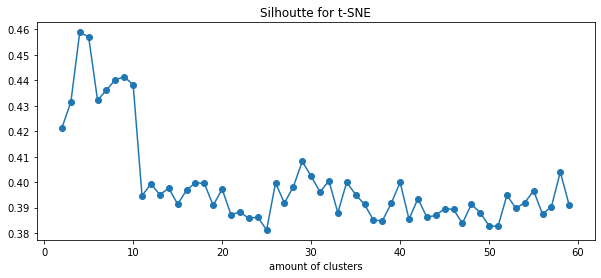

In [44]:
fig = plt.figure(figsize=(10,4))
from sklearn import cluster, metrics
silhouettes = []
for num_clusters in range(2,60):
    # with unique and randow initialization
    cls = cluster.KMeans(n_clusters = num_clusters,
                        init='k-means++')
    cls.fit(X_norm)
    # computing the shape coefficient
    silh = metrics.silhouette_score(X_norm,cls.labels_)
    silhouettes.append(silh)
    
plt.plot(range(2,60),silhouettes, marker='o')
plt.title('Silhoutte for t-SNE')
plt.xlabel('amount of clusters');

> Looking at the silhouete graph, we see that 4 or 5 would be the optimal number of classes, but as we would like a bit more classes to predict, we'll try the next optima : 8 and 9.

#### K-means with 8 clusters

In [45]:
kmeans = cluster.KMeans(n_clusters=8,init='k-means++')
kmeans.fit(X_norm);

X_labels = kmeans.labels_

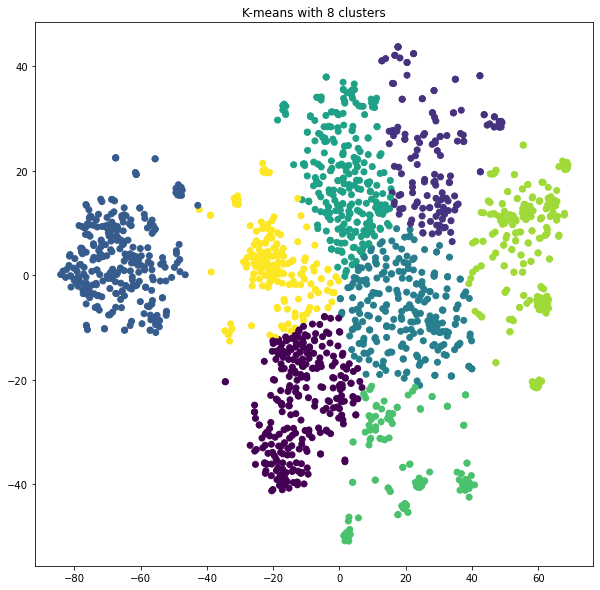

In [46]:
fig = plt.figure(figsize=(10,10))
plt.scatter(X_norm[:,0],X_norm[:,1],c=X_labels)
plt.title("K-means with 8 clusters");

#### K-means with 9 clusters

In [47]:
kmeans_9 = cluster.KMeans(n_clusters=9,init='k-means++')
kmeans_9.fit(X_norm);
X_labels_9 = kmeans_9.labels_

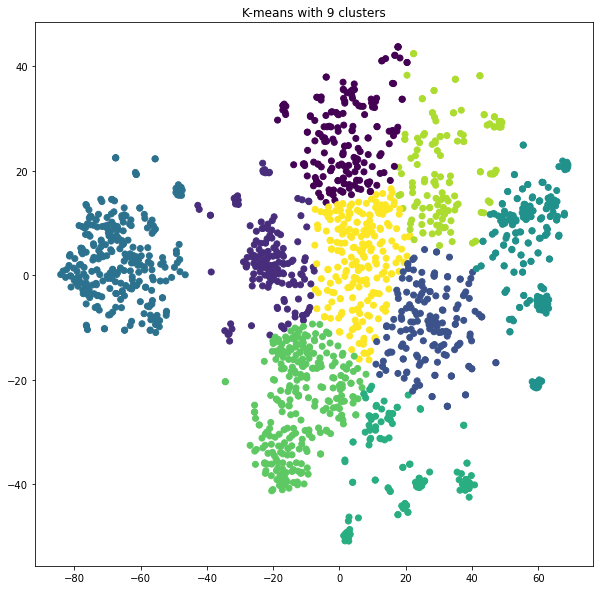

In [48]:
fig = plt.figure(figsize=(10,10))
plt.scatter(X_norm[:,0],X_norm[:,1],c=X_labels_9)
plt.title("K-means with 9 clusters");

#### Addding the different cluster labels to the dataframe

In [49]:
glove_tsne_df['labels_K_8'] = X_labels 
glove_tsne_df['labels_K_9'] = X_labels_9 

In [50]:
glove_tsne_df.sample(20)

emoji_names emoji_symbols          X          Y  \
34             Expressionless Face             😑 -18.347105   0.249714   
489                        Giraffe             🦒 -11.611813 -13.244790   
187               ‍♂️ Man Frowning          🙍‍♂️  53.232777   8.039426   
309                            Elf             🧝  -6.807908  -6.400732   
184                        Old Man             👴  43.669476  30.748714   
75           Sad but Relieved Face             😥 -25.727428   3.773423   
227                ‍⚖️ Woman Judge          👩‍⚖️  67.857658  11.545431   
1067                        Camera             📷   3.753077  34.370358   
1371              Exclamation Mark             ❗ -22.973749  19.757263   
1298            ️ Left-Right Arrow            ↔️  16.341049  36.705845   
726                        Custard             🍮 -22.389231 -37.903374   
1680                 🇼 Flag: Palau            🇵🇼 -62.101288   2.398442   
1449                 Orange Circle             🟠  24.052065 -38.824566   
199           ‍♂️ Man Tipping Hand          💁‍♂️  32.647629  -0.229217   
1605                 🇹 Flag: Italy            🇮🇹 -74.505623  -1.846539   
1162                        ️ Gear            ⚙️  11.078679  14.055515   
277                       Princess             👸  39.389286 -11.726672   
1725              🇿 Flag: Tanzania            🇹🇿 -69.275581   7.652811   
587   Globe Showing Asia-Australia             🌏 -33.365528 -11.241085   
356            Women Holding Hands             👭  33.774956 -19.285753   

      labels_K_8  labels_K_9  
34             7           1  
489            0           6  
187            6           4  
309            7           8  
184            1           7  
75             7           1  
227            6           4  
1067           4           0  
1371           7           1  
1298           1           0  
726            0           6  
1680           2           3  
1449           5           5  
199            3           2  
1605           2           3  
1162           4           8  
277            3           2  
1725           2           3  
587            7           1  
356            3           2

#### Looking at the repartition per cluster for K=8 and K=9

In [51]:
base_color = sb.color_palette()[0]

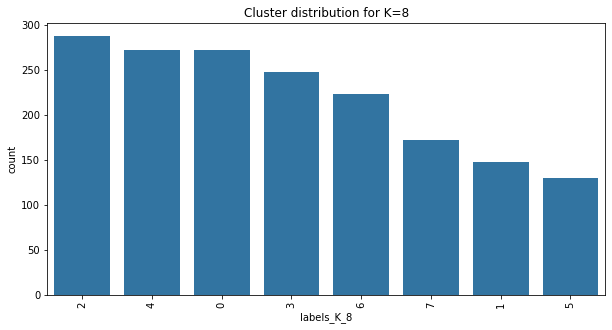

In [52]:
plt.figure(figsize = [10,5])
sb.countplot(data=glove_tsne_df,x='labels_K_8',order=glove_tsne_df.labels_K_8.value_counts().index,
            color=base_color)
plt.xticks(rotation=90)
plt.title('Cluster distribution for K=8');

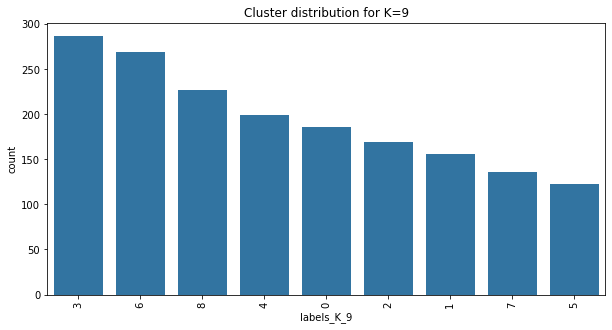

In [53]:
plt.figure(figsize = [10,5])
sb.countplot(data=glove_tsne_df,x='labels_K_9',order=glove_tsne_df.labels_K_9.value_counts().index,
            color=base_color)
plt.xticks(rotation=90)
plt.title('Cluster distribution for K=9');

In [54]:
fig = px.scatter(glove_tsne_df, x='X', y='Y', text='emoji_names', color='labels_K_8')
fig.update_traces(textposition='top center')
fig.update_layout(
        height=1200,
        width=1000,
        title_text="With 8 Clusters")
fig.show()

In [52]:
fig = px.scatter(glove_tsne_df, x='X', y='Y', text='emoji_names', color='labels_K_9')
fig.update_traces(textposition='top center')
fig.update_layout(
        height=1200,
        width=1000,
        title_text="With 9 Clusters")
fig.show()

In [55]:
help(print_samples_cluster)

Help on function print_samples_cluster in module helper_functions:

print_samples_cluster(df, label, n_lines=5)
    Prints samples for each of the clusters 
    
    Parameters:
        df (DataFrame): DataFrame containing emoji_names, emoji_symbols and K_means labels
        label (str): the chosen label (for example in our case: labels_K_8 or labels_K_9)
        n_linles (int): the amount of lines printed per cluster (default = 5)
    
    Returns:
        Prints samples for each of the clusters



In [56]:
print_samples_cluster(glove_tsne_df, 'labels_K_8',10)

Samples from cluster nb 0 
         emoji_names emoji_symbols  labels_K_8
745       Chopsticks             🥢           0
724            Candy             🍬           0
465              Cat             🐈           0
727        Honey Pot             🍯           0
667   Baguette Bread             🥖           0
1361      ️ Multiply            ✖️           0
537            Whale             🐋           0
1315      ️ Yin Yang            ☯️           0
1316   ️ Latin Cross            ✝️           0
514   Hatching Chick             🐣           0

Samples from cluster nb 1 
               emoji_names emoji_symbols  labels_K_8
174    ‍🦰 Person: Red Hair           🧑‍🦰           1
835                   Sled             🛷           1
1259           Loudspeaker             📢           1
1298    ️ Left-Right Arrow            ↔️           1
927                Minibus             🚐           1
915           Bullet Train             🚅           1
282   Woman with Headscarf             🧕           1
170 

In [57]:
print_samples_cluster(glove_tsne_df, 'labels_K_9',10)

Samples from cluster nb 0 
                  emoji_names emoji_symbols  labels_K_8
1004           ️ Bellhop Bell            🛎️           4
1417                CL Button             🆑           4
1373        Currency Exchange             💱           4
1039      ️ Studio Microphone            🎙️           4
1357           Vibration Mode             📳           4
1416  ️ B Button (Blood Type)            🅱️           4
1337     Repeat Single Button             🔂           4
1057              ️ Trackball            🖲️           4
838               Pool 8 Ball             🎱           1
1070            Videocassette             📼           4

Samples from cluster nb 1 
                    emoji_names emoji_symbols  labels_K_8
36                Smirking Face             😏           7
108                   Weary Cat             🙀           7
70                Pleading Face             🥺           7
464                    Cat Face             🐱           7
9              Upside-Down Face        

> Even if the clustering seems good, it's still not optimal. Therefor we'll have a look at the emoji groups and subgroups used on Emojipedia

### Looking at the Emoji Dictionnary
source : https://unicode.org/Public/emoji/13.0/emoji-test.txt

**Categories from emojipedia**
>- 😃 Smileys & People
>- 🐻 Animals & Nature
>- 🍔 Food & Drink
>- ⚽ Activity
>- 🌇 Travel & Places
>- 💡 Objects
>- 🔣 Symbols
>- 🎌 Flags

In [58]:
dict_loc = "./Saved_Variables/unicode_emoji_df.csv"
emoji_dico = pd.read_csv(dict_loc)

In [59]:
emojis.head(3)

Unnamed: 0 emoji_symbol                       emoji_name emoji_code                                  emoji_description                           preprocessed_description                                avg_glove_embedding
0           0            😀                    Grinning Face    U+1F600  A yellow face with simple, open eyes and a bro...  [yellow, face, simple, open, eyes, broad, open...  [-0.05930326535765614, 0.35218397080898284, 0....
1           1            😃      Grinning Face with Big Eyes    U+1F603  A yellow face with smiling eyes and a broad, o...  [yellow, face, smiling, eyes, broad, open, smi...  [-0.04583876235410571, 0.34958994686603545, 0....
2           2            😄  Grinning Face with Smiling Eyes    U+1F604  A yellow face with smiling eyes and a broad, o...  [yellow, face, smiling, eyes, broad, open, smi...  [-0.07637538687036984, 0.3653278946876526, 0.4...

In [60]:
emoji_dico.sample(5)

emoji                                               name            group       sub_group                               codepoints
2932        🧭                                            compass  Travel & Places       place-map                                    1F9ED
2596  👨🏿‍🤝‍👨🏻  men holding hands: dark skin tone, light skin ...    People & Body          family  1F468 1F3FF 200D 1F91D 200D 1F468 1F3FB
2518  🧑🏿‍🤝‍🧑🏻  people holding hands: dark skin tone, light sk...    People & Body          family  1F9D1 1F3FF 200D 1F91D 200D 1F9D1 1F3FB
410         👁                                                eye    People & Body      body-parts                                    1F441
590      🙍🏻‍♂                      man frowning: light skin tone    People & Body  person-gesture                    1F64D 1F3FB 200D 2642

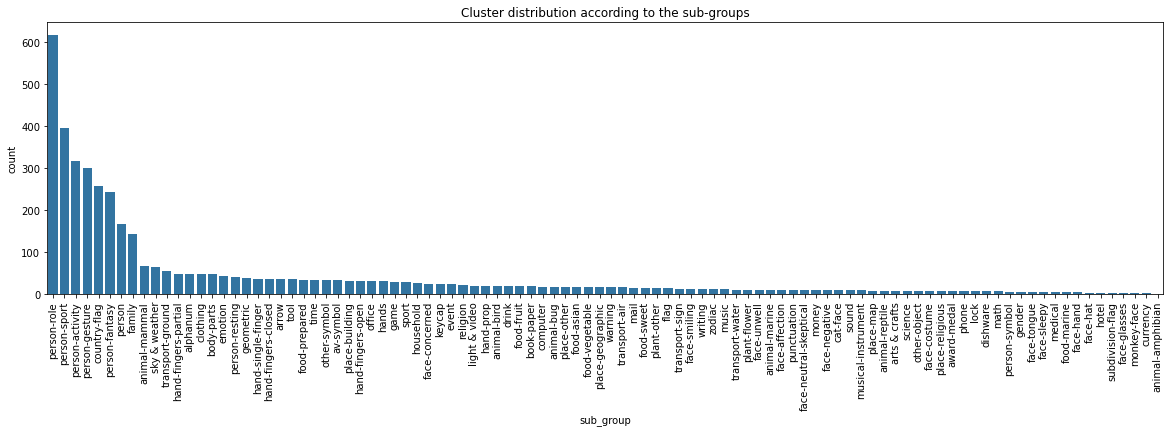

In [61]:
plt.figure(figsize = [20,5])
sb.countplot(data=emoji_dico,x='sub_group',order=emoji_dico.sub_group.value_counts().index,
            color=base_color)
plt.xticks(rotation=90)
plt.title('Cluster distribution according to the sub-groups');

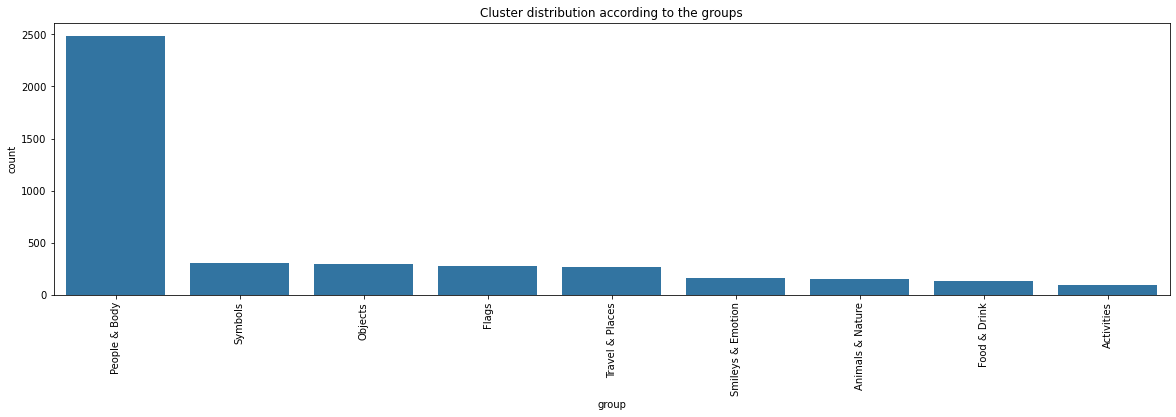

In [62]:
plt.figure(figsize = [20,5])
sb.countplot(data=emoji_dico,x='group',order=emoji_dico.group.value_counts().index,
            color=base_color)
plt.xticks(rotation=90)
plt.title('Cluster distribution according to the groups');

**Idea**
> - As there are too many sub-groups and that the "people & Body" Group is unbalance
> - Keeping the group labels for all groups but the "People & Body" Group, where we take the sub-groups

In [63]:
# Add a column according to this
emoji_dico['label_name'] = emoji_dico.apply(lambda row: row.sub_group if row.group == "People & Body" \
                                            else row.group, axis=1 )

In [64]:
# Test
emoji_dico.sample(20)

emoji                                              name              group         sub_group                  codepoints         label_name
2852      🥚                                               egg       Food & Drink     food-prepared                       1F95A       Food & Drink
3106      🕒                                     three o’clock    Travel & Places              time                       1F552    Travel & Places
2056  🧗🏾‍♀️             woman climbing: medium-dark skin tone      People & Body   person-activity  1F9D7 1F3FE 200D 2640 FE0F    person-activity
3780    2️⃣                                         keycap: 2            Symbols            keycap              0032 FE0F 20E3            Symbols
159       🗯                                right anger bubble  Smileys & Emotion           emotion                       1F5EF  Smileys & Emotion
143       💢                                      anger symbol  Smileys & Emotion           emotion                       1F4A2  Smileys & Emotion
3028      🚗                                        automobile    Travel & Places  transport-ground                       1F697    Travel & Places
863   🤷🏽‍♂️                   man shrugging: medium skin tone      People & Body    person-gesture  1F937 1F3FD 200D 2642 FE0F     person-gesture
1470     🤰🏼            pregnant woman: medium-light skin tone      People & Body       person-role                 1F930 1F3FC        person-role
1540   🦸‍♀️                                   woman superhero      People & Body    person-fantasy        1F9B8 200D 2640 FE0F     person-fantasy
3377      ⌨                                          keyboard            Objects          computer                        2328            Objects
2731      🦜                                            parrot   Animals & Nature       animal-bird                       1F99C   Animals & Nature
1011   🧑🏾‍🍳                       cook: medium-dark skin tone      People & Body       person-role      1F9D1 1F3FE 200D 1F373        person-role
1884  🧎🏼‍♀️            woman kneeling: medium-light skin tone      People & Body   person-activity  1F9CE 1F3FC 200D 2640 FE0F    person-activity
1547   🦸🏽‍♀                 woman superhero: medium skin tone      People & Body    person-fantasy       1F9B8 1F3FD 200D 2640     person-fantasy
2369     🤽🏾  person playing water polo: medium-dark skin tone      People & Body      person-sport                 1F93D 1F3FE       person-sport
3266      ♥                                        heart suit         Activities              game                        2665         Activities
483    👨🏾‍🦲                  man: medium-dark skin tone, bald      People & Body            person      1F468 1F3FE 200D 1F9B2             person
3598      🚸                                 children crossing            Symbols           warning                       1F6B8            Symbols
3961     🇩🇴                          flag: Dominican Republic              Flags      country-flag                 1F1E9 1F1F4              Flags

In [65]:
# Amount of different label_names
emoji_dico['label_name'].nunique()

24

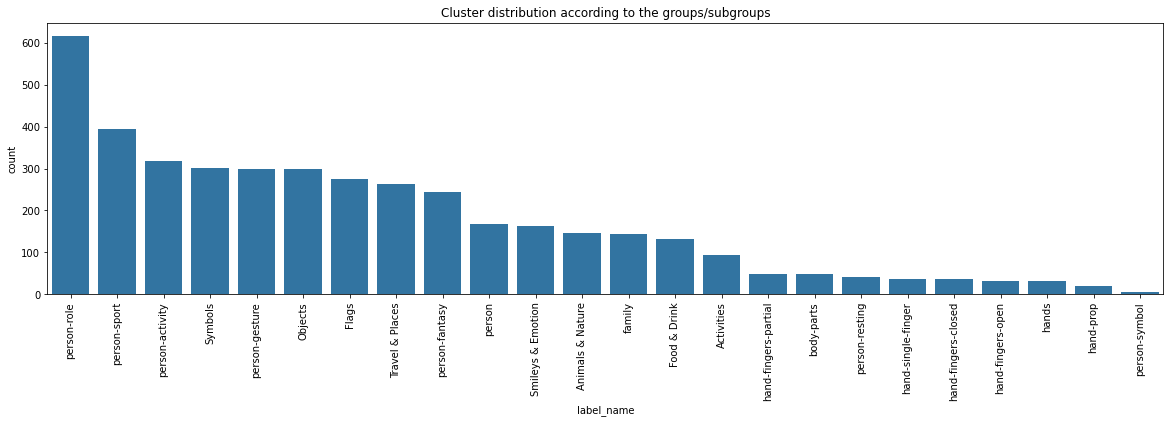

In [66]:
plt.figure(figsize = [20,5])
sb.countplot(data=emoji_dico,x='label_name',order=emoji_dico.label_name.value_counts().index,
            color=base_color)
plt.xticks(rotation=90)
plt.title('Cluster distribution according to the groups/subgroups');

In [67]:
# Import label encoder 
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
emoji_dico['label_num']= label_encoder.fit_transform(emoji_dico['label_name']) 
  


In [68]:
emoji_dico.sample(15)

emoji                                               name              group           sub_group                  codepoints          label_name  label_num
3397      📼                                      videocassette            Objects       light & video                       1F4FC             Objects          4
244      👈🏼  backhand index pointing left: medium-light ski...      People & Body  hand-single-finger                 1F448 1F3FC  hand-single-finger         14
1736    🧞‍♀                                        woman genie      People & Body      person-fantasy             1F9DE 200D 2640      person-fantasy         18
3827      🈂                   Japanese “service charge” button            Symbols            alphanum                       1F202             Symbols          6
15        🤩                                        star-struck  Smileys & Emotion      face-affection                       1F929   Smileys & Emotion          5
1444   👰‍♂️                                      man with veil      People & Body         person-role        1F470 200D 2642 FE0F         person-role         21
845   🤦🏽‍♀️                woman facepalming: medium skin tone      People & Body      person-gesture  1F926 1F3FD 200D 2640 FE0F      person-gesture         19
3633      ↩                           right arrow curving left            Symbols               arrow                        21A9             Symbols          6
1084   🧑🏿‍🔬                          scientist: dark skin tone      People & Body         person-role      1F9D1 1F3FF 200D 1F52C         person-role         21
2         😄                    grinning face with smiling eyes  Smileys & Emotion        face-smiling                       1F604   Smileys & Emotion          5
1489   👨🏽‍🍼                 man feeding baby: medium skin tone      People & Body         person-role      1F468 1F3FD 200D 1F37C         person-role         21
622    🙎🏼‍♂                man pouting: medium-light skin tone      People & Body      person-gesture       1F64E 1F3FC 200D 2642      person-gesture         19
1983     🕺🏻                       man dancing: light skin tone      People & Body     person-activity                 1F57A 1F3FB     person-activity         17
1166   👨🏻‍✈                         man pilot: light skin tone      People & Body         person-role       1F468 1F3FB 200D 2708         person-role         21
2871      🍢                                               oden       Food & Drink          food-asian                       1F362        Food & Drink          3

In [69]:
# Lookup table : emoji_symbol -> label_name
label_lookup = dict(zip(emoji_dico.emoji,emoji_dico.label_name))

In [70]:
with open('Saved_Variables/label_lookup.pkl', 'wb') as f:
    pickle.dump(label_lookup, f)

#### Using this lookup table to add it to the glove_tsne_df

In [71]:
glove_tsne_df['label_name_unicode'] = glove_tsne_df.emoji_symbols.apply(lambda x: label_lookup[x] \
                                                                       if x in label_lookup.keys() \
                                                                        else 'label_not_found')

In [72]:
glove_tsne_df.sample(15)

emoji_names emoji_symbols          X          Y  labels_K_8  labels_K_9  label_name_unicode
787       Person Playing Water Polo             🤽  40.153168   6.167091           6           7        person-sport
1226      ️‍🗨️ Eye in Speech Bubble         👁️‍🗨️  -6.280189  15.737350           4           0   Smileys & Emotion
1435     Japanese “Reserved” Button             🈯   2.805773 -50.867115           5           5             Symbols
1077                      Diya Lamp             🪔  36.811287 -37.962265           5           5             Objects
559                    White Flower             💮   2.128877 -17.927769           0           6    Animals & Nature
125   Backhand Index Pointing Right             👉  28.598219  -0.168320           3           2  hand-single-finger
1522                🇸 Flag: Bahamas            🇧🇸 -62.520386  -0.885725           2           3               Flags
1041                ️ Control Knobs            🎛️   9.324282  16.074139           4           0             Objects
410                           Jeans             👖  29.108603  29.534466           1           7             Objects
882                           Hotel             🏨  15.911772  15.819463           1           8     Travel & Places
196            ‍♂️ Man Gesturing OK          🙆‍♂️  52.034203   4.888725           6           4      person-gesture
406                        Lab Coat             🥼  -0.449697 -13.515523           0           6             Objects
605                    Glowing Star             🌟   4.245415 -10.230127           3           8     Travel & Places
1070                  Videocassette             📼   2.290848  34.936874           4           0             Objects
1139                 Straight Ruler             📏   8.616608   8.941103           4           8             Objects

In [73]:
# Are there a lot of "label_not_found" ?
glove_tsne_df[glove_tsne_df.label_name_unicode=='label_not_found']

emoji_names emoji_symbols          X          Y  labels_K_8  labels_K_9 label_name_unicode
1751  󠁵󠁳󠁴󠁸󠁿 Flag for Texas (US-TX)        🏴󠁵󠁳󠁴󠁸󠁿 -61.600826  19.685867           2           3    label_not_found

> Only one emoji_symbol wasn't found in the dictionary

In [74]:
# Let's correct it
emoji_texas = glove_tsne_df[glove_tsne_df.label_name_unicode=='label_not_found']['emoji_symbols']
emoji_texas = emoji_texas.values[0][0]
label_lookup[emoji_texas] = 'Flags'

In [75]:
emoji_texas

'🏴'

In [76]:
# label_encoder object knows how to understand word labels. 
lbl_name_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
glove_tsne_df['label_num']= lbl_name_encoder.fit_transform(glove_tsne_df['label_name_unicode']) 
  
glove_tsne_df['label_num'].nunique() 

25

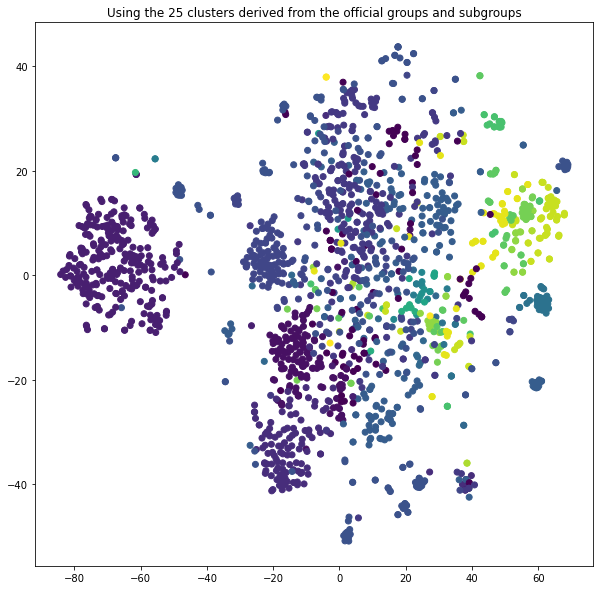

In [77]:
X_lbl_num = list(glove_tsne_df.label_num)

fig = plt.figure(figsize=(10,10))
plt.scatter(X_norm[:,0],X_norm[:,1],c=X_lbl_num)
plt.title("Using the 25 clusters derived from the official groups and subgroups");

<a id='help_function'></a>
## 4. Creating a help DataFrame for Dataset Creation 
<a href="#table">Back to the top </a>

In [78]:
help(df_4_dataset)

Help on function df_4_dataset in module helper_functions:

df_4_dataset(file, emoji_2_embedding_lookup, emoji_symb2emb_dic, n_words=5, n_emoji=5, distance_type='euclidean')
    Returns a DataFrame with nb of original sentence, subsentences and closest
        predicted emoji list for the subsentences
    
    Parameters:
        file (space nlp object): file we want to analyze
    
        emoji_2_embedding_lookup (dict): dictionnary with as keys the words of the
              corpus and the values the vector of that word
    
        emoji_symb2emb_dic (dict): keys emoji_symbols values averaged description Embedding
    
        n_words (int) : size of the sub sentence chunks
    
        n_emoji (int) : size of the predicted emoji list
    
        distance_type (str): default is "euclidiean", but also "cosine" possible
    
    
    Returns:
        A DataFrame with nb of original sentence, subsentences and closest
        predicted emoji list for the subsentences



In [79]:
warnings.filterwarnings('ignore')
df_choose_emoji = df_4_dataset(file_greek, glove_lookup, dict_emoji ,7,20,"euclidean")

In [80]:
df_choose_emoji.head(15)

num_sentence                                       sub_sentence                                     closest_emojis
0              0  STORY <SPACE> <SPACE> <SPACE> <SPACE> <SPACE> ...  [📘, 🧟, 🎞️, 📰, ❤️, 🎥, 🏩, 📕, 📽️, 📗, 👨‍👩‍👧, 〰️, 🖼...
1              1     PART I <SPACE> <SPACE> <SPACE> <SPACE> <SPACE>  [🤍, ❣️, 🧙, 🧚, 🥻, 🩱, 🩳, 🧄, 🧅, 🧇, 🧆, 🧈, 🪂, 🪀, 🪁,...
2              2                 HOW PERSEUS AND HIS MOTHER CAME TO  [👶, 👸, 👨‍👩‍👧, 👨‍👩‍👧‍👦, 🎅, 👨‍👩‍👧‍👧, 👨‍👨‍👧‍👦, 👨‍...
3              2  SERIPHOS <SPACE> <SPACE> <SPACE> <SPACE> <SPAC...                                                 []
4              3                    Once upon a time there were two  [👬, 🙌, 🤼, ⏮️, 🏊, 🔀, 🚶, 🔞, 🎶, 🏃, 🤍, 🙋, 🧑‍🤝‍🧑, 💕...
5              3     princes who were twins <SPACE> <SPACE> <SPACE>  [👼, 👑, 👹, 🎎, 🦇, 🦜, 🙈, 👨‍👨‍👧‍👧, 🐜, 🔱, 👸, 🙉, 💤, ...
6              4          Their names were Acrisius and Proetus and  [☑️, ☎️, 🍩, 🐦, ➡️, ⬇️, ⬅️, ◀️, 🍔, ✔️, 📝, 🐾, 📜,...
7              4                 they lived in the pleasant vale of  [🥀, 🍀, 🎅, ☘️, 🚕, 🌺, 🏠, 🎍, 🌸, 🌼, 🌴, 🚣, 🐚, 😔, 🌫️...
8              4           Argos far away in Hellas <SPACE> <SPACE>  [✨, 🐚, 📨, 🌟, 🦔, 🦉, 💢, ☄️, 💩, 🦦, ✒️, 🎯, 🦗, 🐸, 🎈...
9              5      They had fruitful meadows and vineyards sheep  [🌾, 🌵, 🌴, 🏡, 🦌, 🍇, 🍓, 🌳, 🐡, 🐄, 🍋, 🥬, 🥒, 🥯, 🍀, ...
10             5             and oxen great herds of horses feeding  [🐎, 🐖, 🐂, 🐄, 🐏, 🦌, 🐕, 🐍, 🦀, 🐩, 🦎, 🦙, 🐥, 🐹, 🐃, ...
11             5                     down in Lerna Fen and all that  [🍩, 🥙, 🍔, 🦌, 🥒, 🍈, 🥜, 🥟, 🐡, 🛷, 🥯, 🐄, 🥴, 🥶, 🦉, ...
12             5                  men could need to make them blest  [😎, 🚶, 🙊, 🙅, 🥱, 🤗, 🤰, 📋, 💂, 📄, 🏃, 🙋, 🧸, 🤲, 🔰, ...
13             5            and yet they were wretched because they  [😔, 😜, ☹️, 🙈, 🙎, 😛, 💤, 😉, 🤪, 🚯, 😥, 🤤, 🙉, 🙄, 💩,...
14             5         were jealous of each other <SPACE> <SPACE>  [👺, 😔, 😙, 😛, 😗, 😝, 😍, 🤮, 😠, 😉, 😂, 🥺, 😥, 😘, 😪, ...

In [42]:
# Test with pickle save list
with open('Saved_Variables/sub_sentence_list.pkl', 'wb') as f:
    pickle.dump(list(df_choose_emoji.sub_sentence), f)
    

with open('Saved_Variables/closest_emojis_list.pkl', 'wb') as f:
    pickle.dump(list(df_choose_emoji.closest_emojis), f)